In [ ]:
# 官方教程文档
# https://python.langchain.com/docs/tutorials/qa_chat_history/

In [ ]:
# 构建RAG应用程序：第二部分
# 在许多问答应用程序中，我们希望用户能够进行来回的对话，这意味着应用程序需要某种“记忆”来记住过去的问答，并具备将这些信息融入当前思考的逻辑。

# 本教程是多部分教程的第二部分：

# 第一部分介绍了RAG并展示了一个最小实现。
# 第二部分（本指南）将扩展实现，以适应对话式交互和多步检索过程。
# 在这里，我们将重点放在添加整合历史消息的逻辑上，这涉及到聊天历史的管理。我们将涵盖两种方法：

# 链（Chains）: 最多执行一个检索步骤。
# 代理（Agents）: 赋予LLM自由裁量权，以执行多个检索步骤。
# 注意: 这里介绍的方法利用了现代聊天模型的工具调用能力。

# 对于外部知识源，我们将继续使用第一部分中Lilian Weng的博客文章“LLM Powered Autonomous Agents”。

In [ ]:
# 环境设置 (Setup)
# 在开始之前，我们需要安装一些必要的库并配置LangSmith（可选，但强烈推荐用于跟踪应用）。

# 1.安装依赖:
# 打开您的PowerShell命令行，然后执行以下pip安装命令。

In [ ]:
# pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph beautifulsoup4 langchain langchain-core
# pip install -qU "langchain[google-genai]"
# pip install -qU langchain-google-genai
# pip install -qU langchain-chroma

In [ ]:
# --quiet 或 -q 参数是为了在安装过程中减少输出信息。
# -U 参数是为了确保安装的库是最新版本。
# 我额外添加了 langchain 和 langchain-core，以确保所有LangChain相关的核心组件都更新到最新，避免潜在的MRO（Method Resolution Order）错误。

In [ ]:
# 2.LangSmith 配置 (可选但推荐):
# LangSmith 是 LangChain 应用程序的调试、测试、评估和监控平台。它能帮助我们追踪复杂应用中的LLM调用。

# 首先，您需要注册 LangSmith 并获取 LANGSMITH_API_KEY。然后，在您的PowerShell环境中设置环境变量：

In [ ]:
# $env:LANGSMITH_TRACING="true"
# $env:LANGSMITH_API_KEY="YOUR_LANGSMITH_API_KEY"

In [ ]:
# 请将 YOUR_LANGSMITH_API_KEY 替换为您自己的LangSmith API Key。

# 或者，如果您在Jupyter Notebook中运行，可以使用Python代码设置：

In [ ]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
# 如果您已经在PowerShell中设置了LANGSMITH_API_KEY，这里可以省略，
# 否则，您可以通过getpass输入或直接赋值
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API Key: ")
print("LangSmith 跟踪已启用。")

In [ ]:
# 3.组件选择:
# 我们将从LangChain的集成套件中选择三个核心组件：

# 选择聊天模型 (Chat Model):
# 我们将使用Google Gemini模型。您需要一个Google Gemini API Key。

In [1]:
import getpass
import os
from langchain.chat_models import init_chat_model

# 确保GOOGLE_API_KEY环境变量已设置
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

# 初始化聊天模型。 "gemini-2.5-flash"是模型名称，model_provider指定提供者。
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
print("聊天模型 (LLM) 已初始化。")

聊天模型 (LLM) 已初始化。


In [ ]:
# 选择嵌入模型 (Embeddings Model):
# 我们将使用Google Generative AI Embeddings。

In [2]:
import getpass
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# 确保GOOGLE_API_KEY环境变量已设置
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

# 初始化嵌入模型。 "models/gemini-embedding-001"是嵌入模型的名称。
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
print("嵌入模型 (Embeddings Model) 已初始化。")

嵌入模型 (Embeddings Model) 已初始化。


In [ ]:
# 选择向量存储 (Vector Store):
# 我们将使用Chroma作为向量存储，它是一个轻量级的本地向量数据库。

In [3]:
from langchain_chroma import Chroma

# 初始化向量存储
# collection_name: 存储文档的集合名称，用于区分不同的数据集。
# embedding_function: 指定用于生成文档嵌入的函数，这里使用我们之前初始化的embeddings模型。
# persist_directory: 指定数据本地保存的路径。如果不需要持久化（例如每次运行都重新生成），可以移除此参数。
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",
)
print("向量存储 (Vector Store) 已初始化。")

向量存储 (Vector Store) 已初始化。


In [ ]:
# 链 (Chains)
# 首先，让我们重新审视第一部分中构建的向量存储，它索引了Lilian Weng的博客文章“LLM Powered Autonomous Agents”。

In [4]:
import bs4 # 用于HTML解析
from langchain import hub # 用于从LangChain Hub拉取提示模板
from langchain_community.document_loaders import WebBaseLoader # 用于从网页加载文档
from langchain_core.documents import Document # LangChain文档的基本数据结构
from langchain_text_splitters import RecursiveCharacterTextSplitter # 用于递归文本分割
from typing_extensions import List, TypedDict # 用于类型提示

# --- 1. 索引阶段：加载并分块博客内容 ---
print("开始加载文档...")
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",), # 指定要加载的网页URL
    bs_kwargs=dict( # 传递给BeautifulSoup解析器的关键字参数
        parse_only=bs4.SoupStrainer( # BeautifulSoup的过滤器，只解析指定class的HTML标签
            class_=("post-content", "post-title", "post-header") # 仅保留文章内容、标题和头部
        )
    ),
)
docs = loader.load() # 加载文档，返回Document对象列表
print(f"文档加载完成，共 {len(docs)} 篇文档。")

print("开始分割文档...")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # 每个文本块的最大字符数
    chunk_overlap=200 # 文本块之间的重叠字符数，有助于保持上下文
)
all_splits = text_splitter.split_documents(docs) # 分割文档，返回更小的Document对象列表
print(f"文档分割完成，共 {len(all_splits)} 个文本块。")

# --- 2. 索引文本块到向量存储 ---
print("开始索引文本块到向量存储...")
# 将所有分割后的文档添加到向量存储中。`_` 表示我们不关心返回的文档ID。
_ = vector_store.add_documents(documents=all_splits)
print("文本块索引完成。")

USER_AGENT environment variable not set, consider setting it to identify your requests.


开始加载文档...
文档加载完成，共 1 篇文档。
开始分割文档...
文档分割完成，共 63 个文本块。
开始索引文本块到向量存储...
文本块索引完成。


In [ ]:
# 这段代码与第一部分中的索引部分完全相同，它确保我们的向量存储是最新的，包含了博客文章的嵌入式文本块。

In [ ]:
# 在RAG教程的第一部分中，我们将用户输入、检索到的上下文和生成的答案表示为状态中的独立键。对话体验可以用一系列消息自然地表示。除了来自用户和助手的消息外，检索到的文档和其他工件可以通过工具消息（Tool Messages）合并到消息序列中。这促使我们使用消息序列来表示RAG应用程序的状态。具体来说，我们将有：

# 用户输入作为 HumanMessage；
# 向量存储查询作为带有工具调用的 AIMessage；
# 检索到的文档作为 ToolMessage；
# 最终响应作为 AIMessage。
# LangGraph提供了一个内置的 MessagesState，以方便这种状态模型：

In [5]:
from langgraph.graph import MessagesState, StateGraph

# StateGraph 是 LangGraph 中用于定义图的基类。
# MessagesState 是 LangGraph 提供的一个特殊的状态类型，它将所有消息存储在一个列表中。
# 每次更新状态时，新消息都会被追加到 'messages' 列表中，而不是覆盖现有状态。
graph_builder = StateGraph(MessagesState)
print("LangGraph 的 MessagesState 已初始化。")

LangGraph 的 MessagesState 已初始化。


In [ ]:
# MessagesState 的使用极大地简化了对话历史的管理，因为它自动处理消息的追加，使我们能够轻松地构建具有记忆的对话应用程序。

# 利用工具调用与检索步骤进行交互还有另一个好处，即检索的查询是由我们的模型生成的。这在对话设置中尤其重要，因为用户查询可能需要根据聊天历史进行上下文化。例如，考虑以下对话：

# Human: “什么是任务分解？”
# AI: “任务分解涉及将复杂任务分解为更小、更简单的步骤，使其更易于代理或模型管理。”
# Human: “有哪些常见方法？”
# 在这种情况下，模型可以生成一个查询，例如“任务分解的常见方法”。工具调用自然地促进了这一点。正如RAG教程的查询分析部分一样，这允许模型将用户查询重写为更有效的搜索查询。它还支持不涉及检索步骤的直接响应（例如，响应用户的通用问候）。

# 现在，让我们将检索步骤转换为一个工具：

In [6]:
from langchain_core.tools import tool # 导入 tool 装饰器，用于将函数转换为工具

@tool(response_format="content_and_artifact") # 使用 @tool 装饰器将 retrieve 函数注册为一个工具
def retrieve(query: str):
    """
    检索工具：根据查询从向量存储中检索相关信息。
    此工具被设计为由LLM调用，用于执行信息检索。

    Args:
        query (str): 用于搜索向量存储的查询字符串。

    Returns:
        tuple[str, List[Document]]:
            - str: 序列化后的文档内容，用于LLM生成答案。
            - List[Document]: 原始的检索到的文档对象列表，作为工件存储在状态中。
    """
    print(f"--- 正在执行工具: retrieve, 查询: '{query}' ---")
    # 从向量存储中执行相似性搜索，k=2表示检索最相似的2个文档。
    retrieved_docs = vector_store.similarity_search(query, k=2)
    # 将检索到的文档内容格式化为字符串，每个文档包含其元数据和内容。
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    print(f"--- 工具 'retrieve' 执行完成，检索到 {len(retrieved_docs)} 篇文档 ---")
    # 返回序列化内容和原始文档列表。
    # response_format="content_and_artifact" 允许工具返回两个值：
    # 第一个值 (serialized) 作为 ToolMessage 的内容，
    # 第二个值 (retrieved_docs) 作为 ToolMessage 的附加工件 (artifact) 存储。
    return serialized, retrieved_docs

print("检索工具 'retrieve' 已定义。")

检索工具 'retrieve' 已定义。


In [ ]:
# @tool(response_format="content_and_artifact") 详解：

# @tool 装饰器：这是LangChain提供的一种将普通Python函数转换为可被LLM调用的“工具”的方式。当LLM被赋予使用工具的能力时，它可以通过生成一个特殊的“工具调用”来调用这些函数。
# response_format="content_and_artifact"：这个参数告诉LangGraph（或LangChain的工具调用机制）如何处理工具的返回值。
# content：工具返回的第一个值（这里是 serialized 字符串）将被用作 ToolMessage 的主要内容。LLM在后续生成答案时会直接看到这个内容。
# artifact：工具返回的第二个值（这里是 retrieved_docs 列表）将被存储在 ToolMessage 的 additional_kwargs 字段中。这允许我们保留原始的文档对象，以便在需要时进行进一步处理或调试，而LLM的上下文不会被这些原始对象占用。

In [ ]:
# 我们的图将由三个节点组成：

# 1.query_or_respond 节点: 处理用户输入，要么生成一个用于检索器的查询，要么直接响应。
# 2.tools 节点: 执行检索工具。
# 3.generate 节点: 使用检索到的上下文生成最终响应。
# 我们将在下面构建它们。请注意，我们利用了另一个预构建的LangGraph组件 ToolNode，它执行工具并将结果作为 ToolMessage 添加到状态中。

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage # 导入不同类型的消息
from langgraph.prebuilt import ToolNode # 导入 LangGraph 的预构建 ToolNode

# --- 节点 1: query_or_respond ---
# 这个节点负责接收用户输入，并决定是调用检索工具还是直接回复。
def query_or_respond(state: MessagesState):
    """
    生成工具调用进行检索或直接响应。
    这个节点是图的入口点，LLM会根据对话历史和当前用户输入决定下一步行动。
    """
    print("--- 正在执行节点: query_or_respond ---")
    # 将 retrieve 工具绑定到 LLM。这意味着 LLM 现在知道如何使用这个工具。
    # llm_with_tools 变成了一个 Runnable，当它认为合适时，可以生成一个 ToolCall。
    llm_with_tools = llm.bind_tools([retrieve])
    
    # 调用 LLM，传入当前的状态消息列表。LLM会根据这些消息决定是生成一个普通回复
    # 还是一个工具调用。
    response = llm_with_tools.invoke(state["messages"])
    
    # MessagesState 的特点是它将新消息追加到状态的 'messages' 列表中，而不是覆盖。
    # 因此，我们返回一个包含新生成响应的字典，LangGraph 会将其追加到 `state["messages"]`。
    print(f"--- 节点 'query_or_respond' 完成，LLM响应类型: {response.type} ---")
    return {"messages": [response]}

# --- 节点 2: tools ---
# 这个节点负责执行 LLM 生成的工具调用。
# ToolNode 是 LangGraph 的一个预构建节点，它会自动解析并执行 LLM 生成的工具调用。
# 它接收一个工具列表作为参数。
tools = ToolNode([retrieve])
print("工具节点 'tools' (ToolNode) 已初始化。")

# --- 节点 3: generate ---
# 这个节点负责使用检索到的内容（如果有）和对话历史生成最终答案。
def generate(state: MessagesState):
    """
    生成答案。
    这个节点在工具执行完毕后被调用，用于整合检索到的信息和对话历史来生成用户最终看到的答案。
    """
    print("--- 正在执行节点: generate ---")
    # 获取最近的工具消息。这些消息包含了检索工具的执行结果。
    recent_tool_messages = []
    # 从消息列表的末尾向前遍历，查找类型为 "tool" 的消息。
    # 这样做是为了确保我们只获取当前回合相关的工具消息。
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            # 如果遇到非工具消息，说明已经超出了当前工具调用的范围，停止遍历。
            break
    # 将工具消息列表反转，使其按时间顺序排列（从旧到新）。
    tool_messages = recent_tool_messages[::-1]

    # 从工具消息中提取检索到的文档内容。
    # 每个 tool_message.content 包含了 retrieve 工具返回的序列化文档内容。
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    
    # 构建系统消息的内容，其中包含通用指令和检索到的上下文。
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"Retrieved Context:\n{docs_content}" # 明确标记这是检索到的上下文
    )
    
    # 过滤出用于生成最终答案的对话消息。
    # 这里我们只保留 HumanMessage、SystemMessage，以及不包含工具调用的 AIMessage。
    # 这样可以避免将LLM内部的工具调用思考过程暴露给最终用户。
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    
    # 构建最终的提示列表，系统消息在前，对话消息在后。
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # 调用 LLM 生成最终的响应。
    response = llm.invoke(prompt)
    
    # 将生成的响应作为新的 AIMessage 追加到状态中。
    print(f"--- 节点 'generate' 完成，生成答案: {response.content[:50]}... ---")
    return {"messages": [response]}

print("生成节点 'generate' 已定义。")

工具节点 'tools' (ToolNode) 已初始化。
生成节点 'generate' 已定义。


In [ ]:
# query_or_respond 节点详解：

# llm.bind_tools([retrieve])：这是LangChain中一个强大的功能。它将一个或多个工具（这里是我们的 retrieve 工具）“绑定”到LLM上。这意味着LLM在生成响应时，除了生成文本，还可以选择生成一个 ToolCall，指示它想要调用哪个工具以及传递什么参数。
# llm_with_tools.invoke(state["messages"])：LLM接收当前所有的对话消息。如果它判断需要外部信息来回答问题，它会生成一个 ToolCall；如果它可以直接回答，或者只是一个问候，它会生成一个普通文本回复。
# return {"messages": [response]}：LangGraph的 MessagesState 会自动将这个 response 追加到 state["messages"] 列表中。

In [ ]:
# generate 节点详解：

# recent_tool_messages 提取：为了确保只使用与当前问题相关的检索结果，我们从 state["messages"] 中反向遍历，收集最近的 ToolMessage。
# system_message_content 构建：将检索到的 docs_content 嵌入到系统提示中，明确告诉LLM这是它应该用来回答问题的上下文。
# conversation_messages 过滤：这个列表只包含实际的对话消息，排除了LLM内部生成的工具调用消息，确保最终呈现给用户的对话是清晰和自然的。
# llm.invoke(prompt)：最后，将包含系统指令、检索上下文和过滤后对话历史的完整提示传递给LLM，生成最终的用户可见答案。

In [ ]:
# 最后，我们编译我们的应用程序到一个单一的图对象中。在这个例子中，我们只是将这些步骤连接成一个序列。我们还允许第一个 query_or_respond 步骤“短路”（short-circuit），如果它没有生成工具调用，则直接响应用户。这使得我们的应用程序能够支持对话体验——例如，响应不需要检索步骤的通用问候。

In [8]:
from langgraph.graph import END # 导入 LangGraph 的 END 节点，表示图的终止
from langgraph.prebuilt import tools_condition # 导入 LangGraph 的预构建条件函数

print("开始构建和编译LangGraph应用程序...")
# 添加节点到图构建器
graph_builder.add_node(query_or_respond) # 添加处理用户输入/生成查询的节点
graph_builder.add_node(tools) # 添加执行工具的节点
graph_builder.add_node(generate) # 添加生成最终答案的节点

# 设置图的入口点
graph_builder.set_entry_point("query_or_respond") # 应用程序从 query_or_respond 节点开始执行

# 添加条件边：根据 query_or_respond 的输出决定下一步走向
# tools_condition 是 LangGraph 的一个预构建函数，它检查LLM的响应是否包含工具调用。
# 如果包含工具调用，则走向 "tools" 节点。
# 如果不包含工具调用（即LLM直接生成了答案），则走向 END 节点，结束执行。
graph_builder.add_conditional_edges(
    "query_or_respond", # 条件判断的来源节点
    tools_condition,    # 用于判断的条件函数
    {
        END: END,       # 如果条件函数返回 END，则图执行结束
        "tools": "tools" # 如果条件函数返回 "tools"，则图执行转向 "tools" 节点
    },
)

# 添加常规边：定义确定性的流程
graph_builder.add_edge("tools", "generate") # "tools" 节点执行完毕后，总是转向 "generate" 节点
graph_builder.add_edge("generate", END) # "generate" 节点执行完毕后，总是转向 END 节点，结束执行

# 编译图，生成可执行的应用程序
graph = graph_builder.compile()
print("LangGraph应用程序编译完成。")

开始构建和编译LangGraph应用程序...
LangGraph应用程序编译完成。


In [ ]:
# graph_builder.add_conditional_edges 详解：

# 这是LangGraph中实现条件逻辑的关键。它允许图根据某个节点的输出动态地选择下一个执行路径。
# "query_or_respond"：指定了条件判断发生在哪一个节点之后。
# tools_condition：这是一个函数，它会检查 query_or_respond 节点产生的最新消息。如果消息包含 tool_calls（即LLM决定调用工具），它会返回一个特定的键（通常是 tools）；如果消息不包含 tool_calls（即LLM直接给出了文本响应），它会返回 END。
# {END: END, "tools": "tools"}：这是一个映射，将 tools_condition 的返回值映射到下一个节点。
# END: END：如果 tools_condition 返回 END，则图的执行终止。这处理了LLM直接回答问题或问候的情况。
# "tools": "tools"：如果 tools_condition 返回 "tools"，则图的执行转向名为 "tools" 的节点（即我们的 ToolNode）。

In [ ]:
# LangGraph流程图：

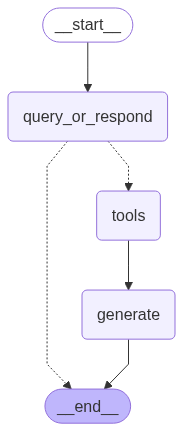

In [9]:
from IPython.display import Image, display

# 绘制Mermaid图并显示
# 注意：这需要在您的环境中安装Graphviz或类似的工具来渲染图像。
# 如果您在JupyterLab中遇到问题，可能需要安装'python-graphviz'和'graphviz'系统包。
# 例如：pip install graphviz 和 sudo apt-get install graphviz (Linux) 或 brew install graphviz (macOS)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 让我们测试我们的应用程序。

# 请注意，它会适当地响应不需要额外检索步骤的消息：

In [10]:
# 确保 graph 变量在此处可用
input_message = "Hello" # 用户输入一个简单的问候

print(f"--- 测试简单问候，输入: '{input_message}' ---")
# 调用图的 stream 方法，以流式模式获取每个步骤的输出。
# stream_mode="values" 表示每个步骤完成后返回整个状态的最新值。
for step in graph.stream(
    {"messages": [HumanMessage(content=input_message)]}, # 初始状态包含一个 HumanMessage
    stream_mode="values",
):
    # 打印每个步骤中最新的消息。
    # pretty_print() 是 LangChain 消息对象的一个方法，用于美观地打印消息内容。
    step["messages"][-1].pretty_print()

--- 测试简单问候，输入: 'Hello' ---
================================ Human Message =================================

Hello
--- 正在执行节点: query_or_respond ---
--- 节点 'query_or_respond' 完成，LLM响应类型: ai ---
================================== Ai Message ==================================

Hello! How can I help you today?


In [ ]:
# 这里 query_or_respond 节点中的LLM判断“Hello”不需要工具调用，直接生成了问候语，并通过 tools_condition 短路到 END。

In [ ]:
# 当执行搜索时，我们可以流式传输步骤，以观察查询生成、检索和答案生成：

In [11]:
# 确保 graph 变量在此处可用
input_message = "What is Task Decomposition?" # 用户输入一个需要检索的问题

print(f"\n--- 测试RAG问答，输入: '{input_message}' ---")
# 以流式模式调用图
for step in graph.stream(
    {"messages": [HumanMessage(content=input_message)]}, # 初始状态包含一个 HumanMessage
    stream_mode="values",
):
    # 打印每个步骤中最新的消息
    step["messages"][-1].pretty_print()


--- 测试RAG问答，输入: 'What is Task Decomposition?' ---
================================ Human Message =================================

What is Task Decomposition?
--- 正在执行节点: query_or_respond ---
--- 节点 'query_or_respond' 完成，LLM响应类型: ai ---
================================== Ai Message ==================================
Tool Calls:
  retrieve (985d37ab-7c6e-4c0d-8b46-18f194f2a90a)
 Call ID: 985d37ab-7c6e-4c0d-8b46-18f194f2a90a
  Args:
    query: Task Decomposition
--- 正在执行工具: retrieve, 查询: 'Task Decomposition' ---
--- 工具 'retrieve' 执行完成，检索到 2 篇文档 ---
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with huma

In [ ]:
# 在这里，LLM 在 query_or_respond 步骤中识别出需要检索，生成了 retrieve 工具调用，tools 节点执行了检索，然后 generate 节点利用检索到的信息和原始问题生成了最终答案。

In [ ]:
# 聊天历史的状态管理 (Stateful management of chat history)
# 在生产环境中，问答应用程序通常会将聊天历史持久化到数据库中，并能够适当地读取和更新它。

# LangGraph 实现了一个内置的持久化层，使其成为支持多轮对话的聊天应用程序的理想选择。

# 为了管理多轮对话和线程，我们所要做的就是在编译应用程序时指定一个 checkpointer。由于图中的节点将消息追加到状态中，我们将在不同的调用中保留一致的聊天历史。

# LangGraph 提供了一个简单的内存检查点器 (MemorySaver)，我们将在下面使用它。有关更多详细信息，包括如何使用不同的持久化后端（例如 SQLite 或 Postgres），请参阅其文档。

In [12]:
from langgraph.checkpoint.memory import MemorySaver # 导入内存检查点器

# 创建一个 MemorySaver 实例。
# MemorySaver 会将图的状态保存在内存中，允许在不同调用之间保持对话历史。
memory = MemorySaver()
print("内存检查点器 (MemorySaver) 已初始化。")

# 重新编译图，并指定 checkpointer。
# 这样，图在每次运行时都会使用 memory 对象来保存和恢复状态。
graph = graph_builder.compile(checkpointer=memory)
print("LangGraph应用程序已使用 MemorySaver 重新编译。")

# 为对话线程指定一个ID。
# 这个ID用于区分不同的对话线程，MemorySaver 会为每个 thread_id 存储独立的对话历史。
config = {"configurable": {"thread_id": "abc123"}}
print(f"已设置对话线程ID: {config['configurable']['thread_id']}")

内存检查点器 (MemorySaver) 已初始化。
LangGraph应用程序已使用 MemorySaver 重新编译。
已设置对话线程ID: abc123


In [ ]:
# MemorySaver 详解：

# MemorySaver 是LangGraph提供的一个简单的持久化实现，它将每个对话线程的状态保存在Python进程的内存中。
# checkpointer=memory：在 graph_builder.compile() 中传入 checkpointer 参数，告诉LangGraph使用这个 memory 对象来管理图的状态持久化。
# config = {"configurable": {"thread_id": "abc123"}}：这是LangChain/LangGraph中用于配置可配置组件（如checkpointer）的标准方式。thread_id 是一个唯一的标识符，用于识别特定的对话会话。每次调用 graph.stream 或 graph.invoke 时，如果传入相同的 thread_id，LangGraph就会加载并更新该 thread_id 对应的历史状态。
# 我们现在可以像以前一样调用：

In [18]:
# 确保 graph 和 config 变量在此处可用
input_message = "What is Task Decomposition?"

print(f"--- 第一次询问，输入: '{input_message}' ---")
for step in graph.stream(
    {"messages": [HumanMessage(content=input_message)]},
    stream_mode="values",
    config=config, # 传入配置，启用状态持久化
):
    step["messages"][-1].pretty_print()

--- 第一次询问，输入: 'What is Task Decomposition?' ---
================================ Human Message =================================

What is Task Decomposition?
--- 正在执行节点: query_or_respond ---
--- 节点 'query_or_respond' 完成，LLM响应类型: ai ---
================================== Ai Message ==================================
Tool Calls:
  retrieve (fc97bc07-e24a-459d-9963-d529e598caf5)
 Call ID: fc97bc07-e24a-459d-9963-d529e598caf5
  Args:
    query: Task Decomposition
--- 正在执行工具: retrieve, 查询: 'Task Decomposition' ---
--- 工具 'retrieve' 执行完成，检索到 2 篇文档 ---
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human i

In [ ]:
# 现在，我们进行第二次询问，这次的问题依赖于之前的上下文：

In [19]:
# 确保 graph 和 config 变量在此处可用
input_message = "Can you look up some common ways of doing it?" # 第二次询问，依赖于“Task Decomposition”的上下文

print(f"\n--- 第二次询问，输入: '{input_message}' ---")
for step in graph.stream(
    {"messages": [HumanMessage(content=input_message)]},
    stream_mode="values",
    config=config, # 再次传入相同的配置，以便加载之前的对话历史
):
    step["messages"][-1].pretty_print()


--- 第二次询问，输入: 'Can you look up some common ways of doing it?' ---
================================ Human Message =================================

Can you look up some common ways of doing it?
--- 正在执行节点: query_or_respond ---
--- 节点 'query_or_respond' 完成，LLM响应类型: ai ---
================================== Ai Message ==================================

Common ways to perform task decomposition include:

1.  **Using an LLM with simple prompting:** This involves giving the LLM prompts like "Steps for XYZ.\n1." or "What are the subgoals for achieving XYZ?" to guide it in breaking down the task.
2.  **Using task-specific instructions:** Providing the LLM with specific instructions tailored to the task, such as "Write a story outline." for a novel-writing task.
3.  **With human inputs:** Directly involving human users to define or refine the sub-tasks.


In [ ]:
# 请注意，在第二个问题中，模型生成的查询 (common methods of task decomposition) 包含了对话上下文。这是因为 query_or_respond 节点中的LLM在生成查询时，能够访问并理解 state["messages"] 中完整的对话历史。

# LangSmith 跟踪在这里特别有信息量，因为我们可以清楚地看到在每个步骤中，聊天模型看到了哪些消息。

In [ ]:
# 代理 (Agents)
# 代理利用LLM的推理能力在执行过程中做出决策。使用代理可以让你在检索过程中获得额外的自由裁量权。虽然它们的行为不如上述“链”可预测，但它们能够执行多个检索步骤以满足查询，或迭代单个搜索。

# 下面我们组装一个最小的RAG代理。使用LangGraph预构建的ReAct代理构造函数，我们可以在一行代码中完成此操作。

# 提示: 查看LangGraph的Agentic RAG教程，了解更高级的代理实现。

In [20]:
from langgraph.prebuilt import create_react_agent # 导入 LangGraph 预构建的 ReAct 代理构造函数

# 使用 create_react_agent 函数创建一个 ReAct 代理。
# llm: 指定用于代理的语言模型。
# tools: 指定代理可以使用的工具列表（这里是我们的 retrieve 工具）。
# checkpointer: 指定用于持久化代理状态的检查点器（这里是之前定义的 memory）。
agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)
print("ReAct 代理 (agent_executor) 已创建并编译。")

ReAct 代理 (agent_executor) 已创建并编译。


In [ ]:
# create_react_agent 详解：

# create_react_agent 是LangGraph提供的一个高级抽象，它基于ReAct（Reasoning and Acting）范式构建了一个代理。
# ReAct 代理的工作原理是：LLM会观察当前的对话历史和工具输出，然后思考（Reason）下一步应该做什么（是回答问题，还是调用工具），然后行动（Act）（调用工具或给出最终答案）。这个过程可以循环多次，直到LLM认为问题已解决。
# 通过 llm 和 [retrieve] 参数，我们告诉代理使用哪个LLM进行推理，以及它可以使用哪些工具。
# checkpointer=memory 确保了代理的对话历史和思考过程也能被持久化，从而支持多轮复杂对话。
# 让我们检查一下代理的图：

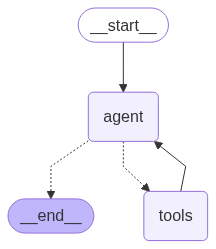

In [21]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
# 代理图与链图的关键区别：

# 循环（Looping）: 代理图的关键区别在于，它不是在 generate 步骤之后结束运行，而是工具调用之后会循环回到原始的LLM调用（这里是 agent 节点）。这意味着LLM可以根据检索到的上下文决定是回答问题，还是生成另一个工具调用以获取更多信息。
# 决策权: 代理赋予LLM更大的决策权，让它自己判断是否需要多次检索，以及如何组合信息来回答复杂问题。
# 让我们测试一下。我们构建一个通常需要迭代检索步骤才能回答的问题：

In [27]:
# 确保 agent_executor 和 memory 变量在此处可用
# 为新的对话线程指定一个ID，以避免与之前的“abc123”线程混淆。
config = {"configurable": {"thread_id": "def222"}}
print(f"已设置新的对话线程ID: {config['configurable']['thread_id']}")

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

print(f"\n--- 测试代理多步检索，输入: '{input_message}' ---")
# 以流式模式调用代理执行器
for event in agent_executor.stream(
    {"messages": [HumanMessage(content=input_message)]},
    stream_mode="values",
    config=config, # 传入配置，启用状态持久化
):
    event["messages"][-1].pretty_print()

已设置新的对话线程ID: def222

--- 测试代理多步检索，输入: 'What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.' ---
================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (fff68099-b7a4-4c93-ab9d-168c474672a8)
 Call ID: fff68099-b7a4-4c93-ab9d-168c474672a8
  Args:
    query: standard method for Task Decomposition
--- 正在执行工具: retrieve, 查询: 'standard method for Task Decomposition' ---
--- 工具 'retrieve' 执行完成，检索到 2 篇文档 ---
================================= Tool Message =================================
Name: retrieve

Source: {'start_index': 2578, 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps 

In [ ]:
# 下一步 (Next steps)
# 我们已经涵盖了构建一个基本的对话式问答应用程序的步骤：

# 我们使用链构建了一个可预测的应用程序，该应用程序为每个用户输入最多生成一个查询。
# 我们使用代理构建了一个可以迭代查询序列的应用程序。
# 要探索不同类型的检索器和检索策略，请访问操作指南的检索器部分。有关LangChain对话记忆抽象的详细演练，请访问如何添加消息历史（记忆）指南。要了解有关代理的更多信息，请查看概念指南和LangGraph代理架构页面。